In [1]:
conda install lightgbm

Retrieving notices: ...working... done
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import datetime
import os

from data_processing import Data

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.svm import SVR

In [4]:
available_data = Data('train').data

In [20]:
available_data

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500
...,...,...,...,...,...,...,...,...,...,...
37132,37132,3.3438,50.0,4.936508,1.079365,1775.0,3.022222,34.19,-118.36,1.856
37133,37133,3.7308,26.0,5.087533,0.966019,1006.0,4.316901,37.32,-121.86,1.588
37134,37134,4.1716,52.0,4.678862,1.101485,1156.0,1.431734,37.75,-122.44,3.387
37135,37135,2.7143,16.0,5.710074,1.068376,584.0,2.803659,38.40,-120.98,1.592


# LightGBM Trial

In [21]:
available_data.isnull().sum()

id             0
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [170]:
# class Data:
#     def __init__(self, data_type: str = 'train', scaler_type: str = 'minmax'):
#         self.data_type = data_type
#         self.data = pd.read_csv('train.csv', index_col=0) if data_type == 'train' else pd.read_csv('test.csv',
#                                                                                                    index_col=0)
#         self.scaler_type = scaler_type
#         if self.data_type == 'train':
#             self.processed_data = self.process_data(self.data, scaler_type=scaler_type, handle_last_col=False)
#         if self.data_type == 'test':
#             self.processed_data = self.process_data(self.data, scaler_type=scaler_type, handle_last_col=True)
#
#     @staticmethod
#     def process_data(df, scaler_type='minmax', handle_last_col=True):
#         raw_cols = df.columns
#         raw_index = df.index
#         if scaler_type == 'minmax':
#             # use minmax scaler
#             scaler = MinMaxScaler()
#
#             if handle_last_col:
#                 # handle all columns
#                 return pd.DataFrame(scaler.fit_transform(df), columns=raw_cols, index=raw_index)
#             else:
#                 # use the original last column
#                 return pd.DataFrame(scaler.fit_transform(df.iloc[:, :-1]), columns=raw_cols[:-1], index=raw_index).join(
#                     df.iloc[:, -1])
#
#         elif scaler_type == 'standard':
#             # use standard scaler
#             scaler = StandardScaler()
#             # use the original last column
#
#             if handle_last_col:
#                 # handle all columns
#                 return pd.DataFrame(scaler.fit_transform(df), columns=raw_cols, index=raw_index)
#             else:
#                 return pd.DataFrame(scaler.fit_transform(df.iloc[:, :-1]), columns=raw_cols[:-1], index=raw_index).\
#                     join(df.iloc[:, -1])
#
#         elif scaler_type == 'none':
#             return df
#
#     def get_train_test_split(self, test_size: float = 0.3, random_state: int = 42):
#         raw_train = pd.read_csv('train.csv', index_col=0)
#         processed_train = self.process_data(raw_train, scaler_type=self.scaler_type, handle_last_col=False)
#
#         X = processed_train.drop('MedHouseVal', axis=1)
#         y = processed_train['MedHouseVal']
#
#         x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
#         return x_train, x_test, y_train, y_test


class Data:
    def __init__(self, data_type: str = 'train', scaler_type: str = 'minmax', use_original_data=False):
        self.data_type = data_type
        self.data = pd.read_csv('train.csv', index_col=0) if data_type == 'train' else pd.read_csv('test.csv',
                                                                                                   index_col=0)
        self.scaler_type = scaler_type
        self.use_original_data = use_original_data

        if self.data_type == 'train':
            self.processed_data = self.process_data(self.data, scaler_type=scaler_type, handle_last_col=False)
        if self.data_type == 'test':
            self.processed_data = self.process_data(self.data, scaler_type=scaler_type, handle_last_col=True)

        if self.use_original_data:
            self.data = self.add_raw_data_to_train(self.data)

    @staticmethod
    def add_raw_data_to_train(df):
        original_df = fetch_california_housing()['data']
        original_df_train = pd.DataFrame(original_df, columns=fetch_california_housing()['feature_names'])
        original_df_train['MedHouseVal'] = fetch_california_housing()['target']
        return pd.concat([df, original_df_train], axis=0)

    @staticmethod
    def process_data(df, scaler_type='minmax', handle_last_col=True):
        raw_cols = df.columns
        raw_index = df.index
        if scaler_type == 'minmax':
            # use minmax scaler
            scaler = MinMaxScaler()

            if handle_last_col:
                # handle all columns
                return pd.DataFrame(scaler.fit_transform(df), columns=raw_cols, index=raw_index)
            else:
                # use the original last column
                return pd.DataFrame(scaler.fit_transform(df.iloc[:, :-1]), columns=raw_cols[:-1], index=raw_index).join(
                    df.iloc[:, -1])

        elif scaler_type == 'standard':
            # use standard scaler
            scaler = StandardScaler()
            # use the original last column

            if handle_last_col:
                # handle all columns
                return pd.DataFrame(scaler.fit_transform(df), columns=raw_cols, index=raw_index)
            else:
                return pd.DataFrame(scaler.fit_transform(df.iloc[:, :-1]), columns=raw_cols[:-1], index=raw_index). \
                    join(df.iloc[:, -1])

        elif scaler_type == 'none':
            return df

    def get_train_test_split(self, test_size: float = 0.3, random_state: int = 42):
        if self.use_original_data:
            raw_train = self.add_raw_data_to_train(pd.read_csv('train.csv', index_col=0))
        else:
            raw_train = pd.read_csv('train.csv', index_col=0)
        processed_train = self.process_data(raw_train, scaler_type=self.scaler_type, handle_last_col=False)

        X = processed_train.drop('MedHouseVal', axis=1)
        y = processed_train['MedHouseVal']

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        return x_train, x_test, y_train, y_test


In [6]:
data = Data('train')
x_train, x_test, y_train, y_test = data.get_train_test_split()

In [55]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 30,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('开始训练...')

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=30,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('保存模型...')
gbm.save_model('lgb_model.txt')

print('开始预测...')
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)

print('预估结果的rmse为:')
print(mean_squared_error(y_test, y_pred) ** 0.5)

开始训练...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's l2: 1.18907	valid_0's auc: 1
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 1.06805	valid_0's auc: 1
[3]	valid_0's l2: 0.954586	valid_0's auc: 1
[4]	valid_0's l2: 0.872976	valid_0's auc: 1
[5]	valid_0's l2: 0.794956	valid_0's auc: 1
[6]	valid_0's l2: 0.729541	valid_0's auc: 1
Early stopping, best iteration is:
[1]	valid_0's l2: 1.18907	valid_0's auc: 1
保存模型...
开始预测...
预估结果的rmse为:
1.0904448638144022


# XGBoost

In [4]:
!pip install xgboost

In [43]:
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [44]:
data = Data('train', scaler_type='none')
x_train, x_test, y_train, y_test = data.get_train_test_split()

In [46]:
n_estimator = list(range(600, 1400, 50))

for estimator in n_estimator:
    print(f'estimator is: {estimator}')
    params = {
        'n_estimators': estimator,
        'max_depth': 5,
        'learning_rate': 0.05,
        'reg_alpha': 0.2,
        'reg_lambda': 0.9,
        'objective': 'reg:squarederror',
        'verbosity': 0
    }

    model = xgb.XGBRegressor(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    print(f'rsme is: ', mean_squared_error(y_pred, y_test) ** 0.5)

estimator is: 600
rsme is:  0.5812846323007027
estimator is: 650
rsme is:  0.5810316614723496
estimator is: 700
rsme is:  0.5810133290652295
estimator is: 750
rsme is:  0.5806905634931286
estimator is: 800
rsme is:  0.5802240949009877
estimator is: 850
rsme is:  0.580156864737305
estimator is: 900
rsme is:  0.5802446862697707
estimator is: 950
rsme is:  0.5803667675349813
estimator is: 1000
rsme is:  0.5801765356170498
estimator is: 1050
rsme is:  0.5805524312937694
estimator is: 1100
rsme is:  0.5803577766312817
estimator is: 1150
rsme is:  0.5802489058385928
estimator is: 1200
rsme is:  0.5802224846522812
estimator is: 1250
rsme is:  0.5803651518358222
estimator is: 1300
rsme is:  0.5801119388262167
estimator is: 1350
rsme is:  0.580027123915484


In [ ]:
# 'learning_rate': 0.05,
# 'reg_alpha': 0.2,
# 'reg_lambda': 0.9,
# estimator is: 1350
# rsme is:  0.5795844871217647



In [47]:
# So maybe we should use 600
params = {
    'n_estimators': 1350,
    'max_depth': 5,
    'learning_rate': 0.05,
    'reg_alpha': 0.2,
    'reg_lambda': 0.9,
    'objective': 'reg:squarederror',
    'verbosity': 0
}

model = xgb.XGBRegressor(**params)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(f'rsme is: ', mean_squared_error(y_pred, y_test) ** 0.5)

rsme is:  0.580027123915484


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

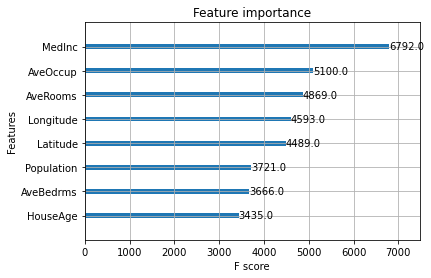

In [48]:
xgb.plot_importance(model)

In [49]:
x_test.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
id,,,,,,,,
31089,5.0855,17.0,6.190805,1.105747,1538.0,3.373563,38.02,-121.36
28863,3.3636,5.0,4.239899,1.020202,3278.0,2.066007,33.68,-117.53
20379,5.0417,29.0,6.602317,1.023529,1119.0,2.705479,33.84,-117.95
3942,4.1364,22.0,5.448584,0.986717,1750.0,3.020478,38.47,-121.77
26360,1.6031,39.0,4.742204,1.075092,1168.0,3.250000,36.75,-119.80


In [51]:
prediction_data = Data('test', scaler_type='none').processed_data
prediction_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
id,,,,,,,,
37137,1.7062,35.0,4.966368,1.096539,1318.0,2.844411,39.75,-121.85
37138,1.3882,22.0,4.187035,1.098229,2296.0,3.180218,33.95,-118.29
37139,7.7197,21.0,7.129436,0.959276,1535.0,2.888889,33.61,-117.81
37140,4.6806,49.0,4.769697,1.048485,707.0,1.743590,34.17,-118.34
37141,3.1284,25.0,3.765306,1.081633,4716.0,2.003827,34.17,-118.29


In [54]:
y_pred = model.predict(prediction_data)

# make to correct format
columns_name = ['MedHouseVal']
df_for_submission = pd.DataFrame(data=y_pred, index=prediction_data.index, columns=columns_name)

# df_for_submission.index.name = 'id'
df_for_submission.to_csv(os.path.join(os.getcwd(), 'for_submission', 'xgb_result_minmax_1350.csv'))

In [53]:
df_for_submission

,MedHouseVal
id,
37137,0.664117
37138,0.990149
37139,3.941533
37140,3.266073
37141,2.348097
...,...
61891,2.436404
61892,1.840928
61893,1.389943


In [20]:
y_pred

array([0.7614966, 1.7046013, 3.6454952, ..., 1.2254455, 3.9944975,
       2.4883578], dtype=float32)

In [122]:
189/289

0.6539792387543253

# SVM-SVR Trial

In [124]:
data = Data('train')
x_train, x_test, y_train, y_test = data.get_train_test_split()

In [131]:
params = {
    'C': 1.0,
    'kernel': 'rbf',
    'gamma': 'auto',
    'cache_size': 100,
    'degree': 3
}

model_svm = SVR(**params)
model_svm.fit(x_train, y_train)

y_pred = model_svm.predict(x_test)

print(f'rsme is: ', mean_squared_error(y_pred, y_test) ** 0.5)

rsme is:  1.0642501029165188


In [126]:
x_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
id,,,,,,,,
17647,4.9643,33.0,5.649425,1.011494,1390.0,2.826271,34.04,-118.48
11010,4.7946,13.0,7.337500,1.031250,1888.0,2.690972,38.65,-121.36
35733,4.7094,13.0,6.527646,1.132189,1884.0,2.935860,33.83,-117.21
6552,5.8898,16.0,6.205937,1.024015,2318.0,3.291809,34.22,-118.88
17191,2.3456,11.0,3.371642,1.139326,729.0,2.539735,34.16,-118.37
...,...,...,...,...,...,...,...,...
16850,2.7797,35.0,4.539378,1.035316,1583.0,3.128959,37.35,-121.86
6265,3.0481,39.0,5.930000,1.171875,779.0,2.738750,35.34,-119.01
11284,3.6346,33.0,5.010462,1.021423,2099.0,2.263598,37.65,-122.43


# Catboost trial

In [56]:
!pip install catboost

  Using cached catboost-1.1.1-cp39-none-macosx_10_6_universal2.whl (22.0 MB)


In [171]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.datasets import fetch_california_housing

In [167]:
original = fetch_california_housing()
print(pd.DataFrame(original['data']).head())
print(pd.DataFrame(original))

        0     1         2         3       4         5      6       7
0  8.3252  41.0  6.984127  1.023810   322.0  2.555556  37.88 -122.23
1  8.3014  21.0  6.238137  0.971880  2401.0  2.109842  37.86 -122.22
2  7.2574  52.0  8.288136  1.073446   496.0  2.802260  37.85 -122.24
3  5.6431  52.0  5.817352  1.073059   558.0  2.547945  37.85 -122.25
4  3.8462  52.0  6.281853  1.081081   565.0  2.181467  37.85 -122.25


ValueError: Per-column arrays must each be 1-dimensional

In [169]:
x_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
id,,,,,,,,
17647,4.9643,33.0,5.649425,1.011494,1390.0,2.826271,34.04,-118.48
11010,4.7946,13.0,7.337500,1.031250,1888.0,2.690972,38.65,-121.36
35733,4.7094,13.0,6.527646,1.132189,1884.0,2.935860,33.83,-117.21
6552,5.8898,16.0,6.205937,1.024015,2318.0,3.291809,34.22,-118.88
17191,2.3456,11.0,3.371642,1.139326,729.0,2.539735,34.16,-118.37
...,...,...,...,...,...,...,...,...
16850,2.7797,35.0,4.539378,1.035316,1583.0,3.128959,37.35,-121.86
6265,3.0481,39.0,5.930000,1.171875,779.0,2.738750,35.34,-119.01
11284,3.6346,33.0,5.010462,1.021423,2099.0,2.263598,37.65,-122.43


In [ ]:
# original = fetch_california_housing()
# df_original = pd.DataFrame(original["data"], columns=original["feature_names"])
# df_original["MedHouseVal"] = original["target"]
#
# df_train = pd.read_csv("train.csv")
# df_test = pd.read_csv("test.csv")
#
# df_train["is_generated"] = True
# df_test["is_generated"] = True
# df_original["is_generated"] = False

In [172]:
data = Data('train', scaler_type='none', use_original_data=True)
x_train, x_test, y_train, y_test = data.get_train_test_split()

In [182]:
cv_params = {'iterations': list(range(10, 100, 10))}
other_params = {
    'iterations': 2200,
    'learning_rate': 0.05,
    'l2_leaf_reg': 3,
    'bagging_temperature': 1,
    'random_strength': 1,
    'depth': 6,
    'rsm': 1,
    'one_hot_max_size': 2,
    'leaf_estimation_method': 'Gradient',
    'fold_len_multiplier': 2,
    'border_count': 400
}

model_cb = CatBoostRegressor(**other_params)

# score = make_scorer(mean_squared_error)
# optimized_cb = GridSearchCV(estimator=model_cb, param_grid=cv_params, scoring=score, cv=5, verbose=1, n_jobs=2)
# optimized_cb.fit(x_train, y_train)
# print('参数最佳取值：', optimized_cb.best_params_)

In [183]:
model_cb.fit(x_train, y_train)

# predict
y_pred = model_cb.predict(x_test)
print(f'rsme is: ', mean_squared_error(y_pred, y_test) ** 0.5)

0:	learn: 1.1249738	total: 2.53ms	remaining: 5.56s
1:	learn: 1.0956607	total: 5.96ms	remaining: 6.55s
2:	learn: 1.0679662	total: 9.32ms	remaining: 6.82s
3:	learn: 1.0420218	total: 12.8ms	remaining: 7s
4:	learn: 1.0170981	total: 16.5ms	remaining: 7.25s
5:	learn: 0.9936321	total: 20.1ms	remaining: 7.37s
6:	learn: 0.9720691	total: 23.7ms	remaining: 7.41s
7:	learn: 0.9513358	total: 28.7ms	remaining: 7.86s
8:	learn: 0.9319834	total: 32.3ms	remaining: 7.86s
9:	learn: 0.9141711	total: 37.3ms	remaining: 8.16s
10:	learn: 0.8975582	total: 40.7ms	remaining: 8.09s
11:	learn: 0.8823173	total: 45.1ms	remaining: 8.22s
12:	learn: 0.8673000	total: 48.8ms	remaining: 8.21s
13:	learn: 0.8535001	total: 54.1ms	remaining: 8.45s
14:	learn: 0.8412093	total: 58.2ms	remaining: 8.48s
15:	learn: 0.8289630	total: 63.1ms	remaining: 8.61s
16:	learn: 0.8167199	total: 69.4ms	remaining: 8.91s
17:	learn: 0.8059338	total: 73.3ms	remaining: 8.89s
18:	learn: 0.7963682	total: 78.4ms	remaining: 9s
19:	learn: 0.7866344	total: 

In [ ]:
0.5216

other_params = {
    'iterations': 1600,
    'learning_rate': 0.05,
    'l2_leaf_reg': 3,
    'bagging_temperature': 1,
    'random_strength': 1,
    'depth': 6,
    'rsm': 1,
    'one_hot_max_size': 2,
    'leaf_estimation_method': 'Gradient',
    'fold_len_multiplier': 2,
    'border_count': 400
}

In [184]:
prediction_data = Data('test', scaler_type='none').processed_data
prediction_data.head()
y_pred = model_cb.predict(prediction_data)

# make to correct format
columns_name = ['MedHouseVal']
df_for_submission = pd.DataFrame(data=y_pred, index=prediction_data.index, columns=columns_name)

# df_for_submission.index.name = 'id'
df_for_submission.to_csv(os.path.join(os.getcwd(), 'for_submission', 'catboost_result_minmax_1600_added_raw.csv'))


In [138]:
290/512

0.56640625

# Adaboost

In [141]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [146]:
data = Data('train', scaler_type='none')
x_train, x_test, y_train, y_test = data.get_train_test_split()

rng = np.random.RandomState(1)

# regr_1 = DecisionTreeRegressor(max_depth=4)
model_ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5),
                              n_estimators=200, random_state=rng, learning_rate=0.1)

model_ada.fit(x_train, y_train)

# predict
y_pred = model_ada.predict(x_test)
print(f'rsme is: ', mean_squared_error(y_pred, y_test) ** 0.5)

rsme is:  0.7313425594456407


# GBDT

In [147]:
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

In [159]:
data = Data('train', scaler_type='none')
x_train, x_test, y_train, y_test = data.get_train_test_split()

params = {'n_estimators': 600,
          'max_depth': 6,
          'min_samples_split': 9,
          'learning_rate': 0.05,
          'loss': 'squared_error'}

GBDTreg = GradientBoostingRegressor(**params)
GBDTreg.fit(x_train, y_train)

y_predict = GBDTreg.predict(x_test)
print(f'rsme is: ', mean_squared_error(y_predict, y_test) ** 0.5)

rsme is:  0.5843091782743876


In [ ]:
rsme is:  0.58

In [ ]:
feature_importance = GBDTreg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(boston.feature_names)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(GBDTreg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(boston.feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Basic Neural Network

In [134]:
!pip install torch

     |████████████████████████████████| 135.3 MB 327 kB/s eta 0:00:01     |███████████████████████████████▎| 132.4 MB 306 kB/s eta 0:00:10


In [7]:
import torch
import numpy as np
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

In [1]:
data = Data('train')
x_train, x_test, y_train, y_test = data.get_train_test_split()

x_train = torch.tensor(x_train.values)
x_test = torch.tensor(x_test.values)
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

NameError: name 'Data' is not defined

In [ ]:
# x_train = torch.from_numpy(x_train.values).float().to('cpu')

In [137]:
seq_net = nn.Sequential(
    nn.Linear(9, 4),  # PyTorch 中的线性层，wx + b
    nn.ReLU(),
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
)

param = seq_net.parameters()
optim = torch.optim.SGD(param, 1.)

# 自定义RMSE，因为只有MSE
def RMSELoss(yhat, y):
    return torch.sqrt(torch.mean((yhat - y) ** 2))

criterion = RMSELoss

# 训练n次
for e in range(10000):
    out = seq_net(Variable(x_train))
    loss = criterion(out, Variable(y_train))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, RMSE loss: {}'.format(e + 1, loss.data[0]))

TypeError: Variable data has to be a tensor, but got DataFrame

In [ ]:
y_pred = seq_net(Variable(x_test))